In [37]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [38]:
sent = np.load("en.1.npz")
T_proj = sent['projection_tensor']
source_langs = sent['source_languages']

In [39]:
T_proj[:,:,0].shape

(11, 12)

In [40]:
D = pd.DataFrame(T_proj[0])
M = T_proj[0] - T_proj[0].min()
M

array([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  3.08067  ,  0.       ,  0.       ,  0.       ],
       [ 4.76991  ,  5.57508  ,  5.75572  ,  4.09001  ,  5.99189  ,
         1.22856  ,  4.78371  ,  0.       ,  5.00559  ,  0.       ,
         5.69874  ,  0.       ,  5.81538  ,  

es.tt.conll


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

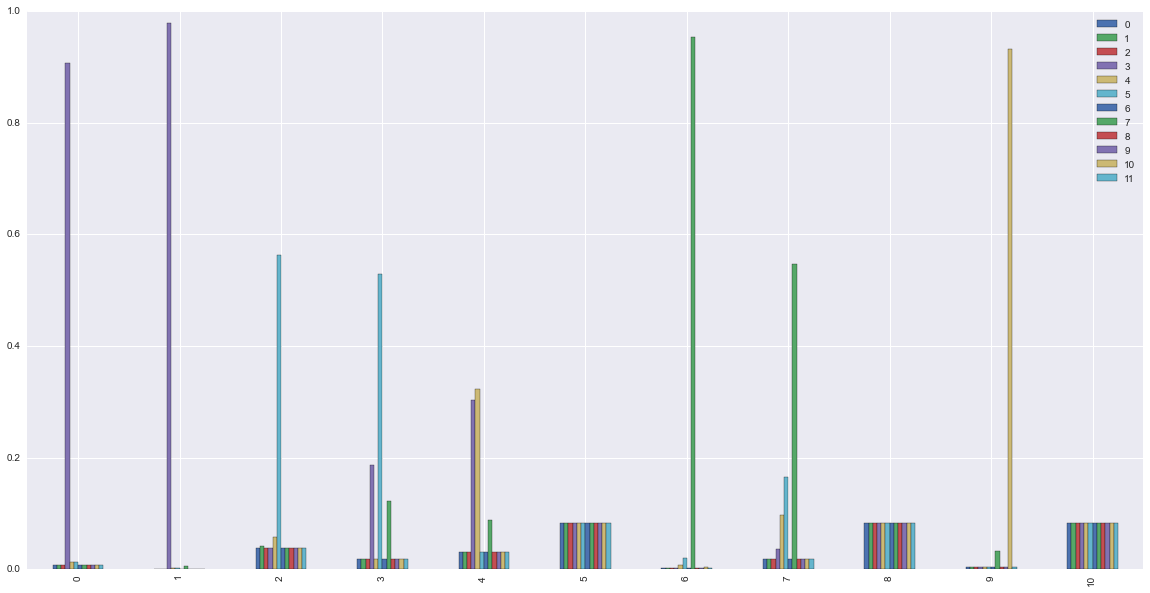

In [41]:
i = 6
print(source_langs[i])
M = T_proj[:,:,i]# - T_proj[:,:,i].min()

def softmax(matrix, temperature=1):
    m_exp = np.exp(matrix/temperature)
    return (m_exp.T / m_exp.sum(axis=1)).T

pd.DataFrame(softmax(M, 1)).plot(kind='bar', figsize=(20, 10))

# M -= M.min(axis=1)

#pd.DataFrame(M) *1

T_proj[:,0,:]
